<a href="https://colab.research.google.com/github/lucabarattini/STAT-5703/blob/main/STAT_5703_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### § Luca Barattini - STAT5703 - Assignment 2:

### Question I:

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

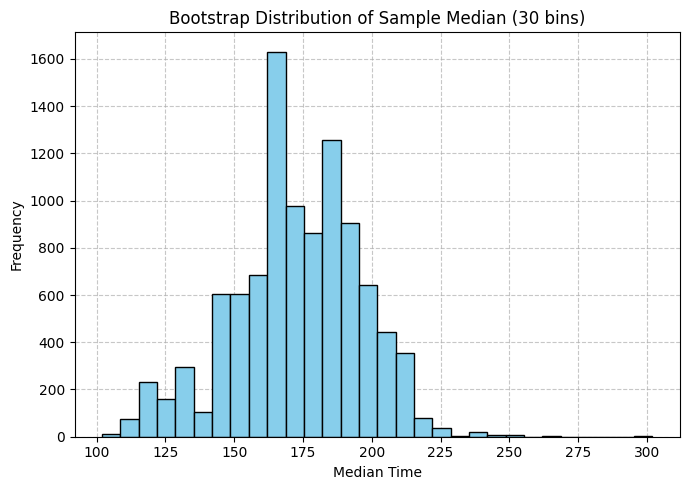

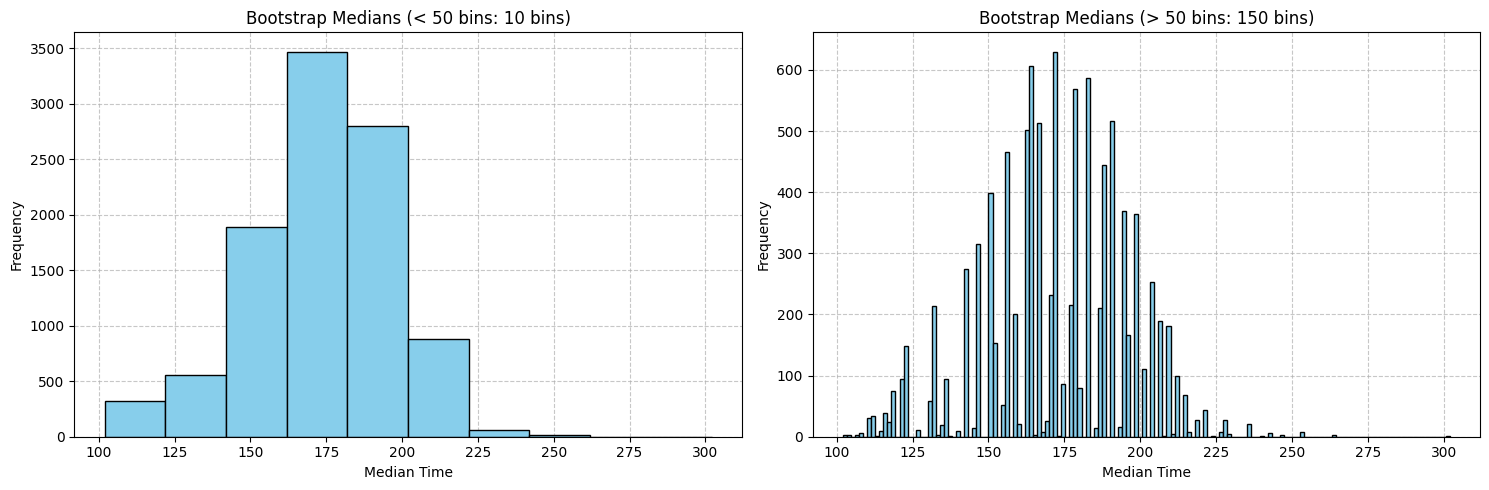

In [29]:
# 1. Load Data and Generate Bootstrap Sample
data = pd.read_table('HW2-irs.txt')
data = data['Time'].values

n = len(data)
B = 10000
bootstrap_medians = np.zeros(B)

for i in range(B):
    boot_sample = np.random.choice(data, size=n, replace=True)
    bootstrap_medians[i] = np.median(boot_sample)

# ---------------------------------------------------------
# Part A: The Standard Histogram
# ---------------------------------------------------------
plt.figure(figsize=(7, 5))
plt.hist(bootstrap_medians, bins=30, edgecolor='black', color='skyblue', zorder=2)
plt.title('Bootstrap Distribution of Sample Median (30 bins)')
plt.grid(True, linestyle='--', alpha=0.7, zorder=1)
plt.xlabel('Median Time')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# Part B: Trying More and Less Bins
# ---------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Less than 50 (10 bins)
axes[0].hist(bootstrap_medians, bins=10, edgecolor='black', color='skyblue', zorder=2)
axes[0].set_title('Bootstrap Medians (< 50 bins: 10 bins)')
axes[0].grid(True, linestyle='--', alpha=0.7, zorder=1)
axes[0].set_xlabel('Median Time')
axes[0].set_ylabel('Frequency')

# More than 50 (150 bins)
axes[1].hist(bootstrap_medians, bins=150, edgecolor='black', color='skyblue', zorder=2)
axes[1].set_title('Bootstrap Medians (> 50 bins: 150 bins)')
axes[1].grid(True, linestyle='--', alpha=0.7, zorder=1)
axes[1].set_xlabel('Median Time')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [23]:
# ---------------------------------------------------------
# Part C: Confidence Interval
# ---------------------------------------------------------
lower_bound = np.percentile(bootstrap_medians, 2.5)
upper_bound = np.percentile(bootstrap_medians, 97.5)
print(f"95% Bootstrap Confidence Interval: ({lower_bound:.2f}, {upper_bound:.2f})")

95% Bootstrap Confidence Interval: (121.00, 212.00)


### Question IV:

In [32]:
import scipy.stats as stats
from scipy.optimize import minimize, root_scalar
from scipy.special import gammaln, polygamma

# The observed sample
x = np.array([0.34, 0.47, 0.42, 0.23, 0.26])
n = len(x)

sum_ln_x = np.sum(np.log(x))
sum_ln_1_minus_x = np.sum(np.log(1 - x))

# ---------------------------------------------------------
# Part A: Wald Confidence Intervals
# ---------------------------------------------------------
# 1. Define negative log-likelihood to minimize
def neg_log_likelihood(params):
    alpha, beta = params
    if alpha <= 0 or beta <= 0:
        return np.inf
    ll = (n * gammaln(alpha + beta) - n * gammaln(alpha) - n * gammaln(beta)
          + (alpha - 1) * sum_ln_x + (beta - 1) * sum_ln_1_minus_x)
    return -ll

# Find MLE
initial_guess = [1.0, 1.0]
mle_result = minimize(neg_log_likelihood, initial_guess, method='L-BFGS-B', bounds=[(1e-5, None), (1e-5, None)])
alpha_mle, beta_mle = mle_result.x

# 2. Compute Fisher Information Matrix (using trigamma = polygamma(1, z))
def fisher_information(alpha, beta, n):
    psi1_alpha = polygamma(1, alpha)
    psi1_beta = polygamma(1, beta)
    psi1_ab = polygamma(1, alpha + beta)

    I_11 = n * (psi1_alpha - psi1_ab)
    I_22 = n * (psi1_beta - psi1_ab)
    I_12 = -n * psi1_ab

    return np.array([[I_11, I_12], [I_12, I_22]])

I_mat = fisher_information(alpha_mle, beta_mle, n)
cov_mat = np.linalg.inv(I_mat)

se_alpha = np.sqrt(cov_mat[0, 0])
se_beta = np.sqrt(cov_mat[1, 1])

z_val = stats.norm.ppf(0.975) # 1.96

ci_alpha = (alpha_mle - z_val * se_alpha, alpha_mle + z_val * se_alpha)
ci_beta = (beta_mle - z_val * se_beta, beta_mle + z_val * se_beta)

print(f"Part a) MLEs: alpha^ = {alpha_mle:.4f}, beta^ = {beta_mle:.4f}")
print(f"Part a) 95% Wald CI for alpha: ({ci_alpha[0]:.4f}, {ci_alpha[1]:.4f})")
print(f"Part a) 95% Wald CI for beta: ({ci_beta[0]:.4f}, {ci_beta[1]:.4f})\n")

Part a) MLEs: alpha^ = 9.2125, beta^ = 17.5689
Part a) 95% Wald CI for alpha: (-2.0251, 20.4500)
Part a) 95% Wald CI for beta: (-4.1418, 39.2795)



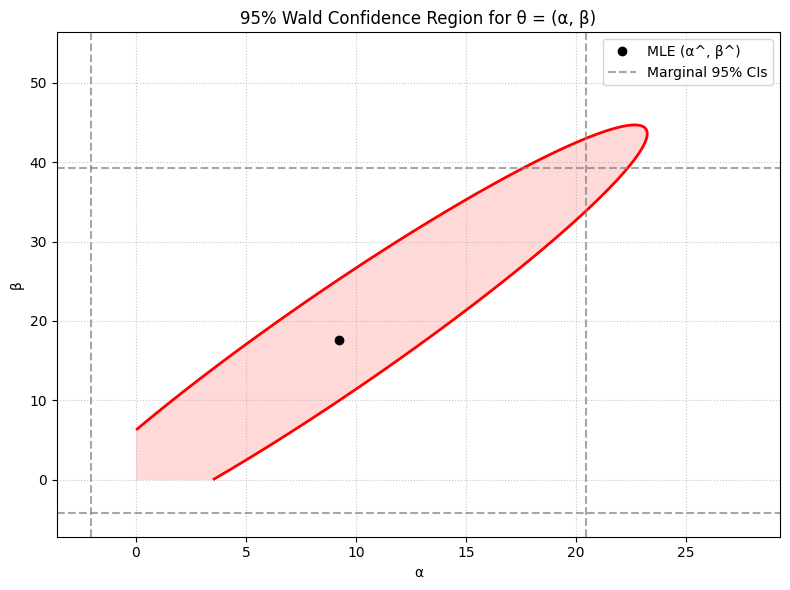

In [34]:
# ---------------------------------------------------------
# Part B: 95% Confidence Oval (Improved)
# ---------------------------------------------------------
chi2_val_2df = stats.chi2.ppf(0.95, df=2) # ~5.991

# 1. Create a finer grid for a smoother oval (200x200)
a_vals = np.linspace(max(0.01, alpha_mle - 3.5*se_alpha), alpha_mle + 3.5*se_alpha, 200)
b_vals = np.linspace(max(0.01, beta_mle - 3.5*se_beta), beta_mle + 3.5*se_beta, 200)
A, B = np.meshgrid(a_vals, b_vals)

# 2. Vectorized evaluation of the quadratic form (Much faster than loops)
diff_A = A - alpha_mle
diff_B = B - beta_mle

# Quadratic form: Z = diff^T * I_mat * diff
Z = (diff_A**2 * I_mat[0, 0] +
     2 * diff_A * diff_B * I_mat[0, 1] +
     diff_B**2 * I_mat[1, 1])

plt.figure(figsize=(8, 6))

# 3. Fill the confidence region and draw the boundary
plt.contourf(A, B, Z, levels=[0, chi2_val_2df], colors=['#ffb3b3'], alpha=0.5)
plt.contour(A, B, Z, levels=[chi2_val_2df], colors='red', linewidths=2)

# 4. Mark the MLE
plt.plot(alpha_mle, beta_mle, 'ko', label='MLE (α^, β^)', markersize=6)

# 5. Overlay Marginal 95% CIs from Part A to show the bounding box
plt.axvline(ci_alpha[0], color='gray', linestyle='--', alpha=0.7, label='Marginal 95% CIs')
plt.axvline(ci_alpha[1], color='gray', linestyle='--', alpha=0.7)
plt.axhline(ci_beta[0], color='gray', linestyle='--', alpha=0.7)
plt.axhline(ci_beta[1], color='gray', linestyle='--', alpha=0.7)

plt.title('95% Wald Confidence Region for θ = (α, β)')
plt.xlabel('α')
plt.ylabel('β')
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [35]:
# ---------------------------------------------------------
# Part C: Profile Likelihood CI for alpha (beta = 1)
# ---------------------------------------------------------
# Exact MLE for alpha when beta = 1
alpha_prof_mle = -n / sum_ln_x

def profile_log_likelihood(alpha):
    return n * np.log(alpha) + (alpha - 1) * sum_ln_x

max_ll_prof = profile_log_likelihood(alpha_prof_mle)
chi2_val_1df = stats.chi2.ppf(0.95, df=1) # ~3.841

# Function to find roots (where ll(alpha) = max_ll - chi2/2)
def target_func(alpha):
    return profile_log_likelihood(alpha) - (max_ll_prof - chi2_val_1df / 2)

# Solve for lower and upper bounds
lower_bound_prof = root_scalar(target_func, bracket=[0.01, alpha_prof_mle]).root
upper_bound_prof = root_scalar(target_func, bracket=[alpha_prof_mle, 10.0]).root

print(f"\nPart c) Constrained MLE (beta=1): alpha^ = {alpha_prof_mle:.4f}")
print(f"Part c) 95% Profile Likelihood CI for alpha: ({lower_bound_prof:.4f}, {upper_bound_prof:.4f})")


Part c) Constrained MLE (beta=1): alpha^ = 0.9061
Part c) 95% Profile Likelihood CI for alpha: (0.3249, 1.9475)
